In [16]:
import tensorflow as tf

# Test to see if TensorFlow can utilize the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [1]:
import gensim
import numpy as np
import pandas as pd

In [7]:
df = pd.read_json(r"Sports_and_Outdoors_5.json", lines = True)

# We give lines = True to avoid trailback error

In [8]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5,Woks very good,1390694400,"01 26, 2014"
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5,Works as well as the factory tool,1328140800,"02 2, 2012"
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4,"It's a punch, that's all.",1330387200,"02 28, 2012"
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4,It's a punch with a Glock logo.,1328400000,"02 5, 2012"
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013"


In [9]:
df.shape

(296337, 9)

In [10]:
review_text = df.reviewText.apply(gensim.utils.simple_preprocess)
review_text

# Do not do this automatic approach for data preprocessing

0         [this, came, in, on, time, and, am, veru, happ...
1         [had, factory, glock, tool, that, was, using, ...
2         [if, you, don, have, punch, or, would, like, t...
3         [this, works, no, better, than, any, punch, yo...
4         [purchased, this, thinking, maybe, need, speci...
                                ...                        
296332    [this, is, water, bottle, done, right, it, is,...
296333    [if, you, re, looking, for, an, insulated, wat...
296334    [this, hydracentials, sporty, oz, double, insu...
296335    [as, usual, received, this, item, free, in, ex...
296336    [hydracentials, insulated, oz, water, bottle, ...
Name: reviewText, Length: 296337, dtype: object

In [11]:
review_text.loc[0]

['this',
 'came',
 'in',
 'on',
 'time',
 'and',
 'am',
 'veru',
 'happy',
 'with',
 'it',
 'haved',
 'used',
 'it',
 'already',
 'and',
 'it',
 'makes',
 'taking',
 'out',
 'the',
 'pins',
 'in',
 'my',
 'glock',
 'very',
 'easy']

## Building word2vec model

In [12]:
model = gensim.models.Word2Vec(vector_size = 100, window = 5, min_count = 2)

# Window size is the number of words taken per cycle
# min_count =  means atleast one focus and one context word needed

model.train(review_text, total_examples = model.corpus_count, epochs = model.epochs)

RuntimeError: you must first build vocabulary before training the model

In [13]:
model = gensim.models.Word2Vec(vector_size = 100, window = 5, min_count = 2)

# Window size is the number of words taken per cycle
# min_count =  means atleast one focus and one context word needed

In [14]:
model.build_vocab(review_text, progress_per = 1000)

# Progress per iteration is indicating how many words to update per cycle

In [15]:
model.train(review_text, total_examples = model.corpus_count, epochs = model.epochs)

(91337188, 121496535)

In [17]:
model.wv.most_similar('abhor')

[('syrup', 0.574129581451416),
 ('lotion', 0.5577570199966431),
 ('proofs', 0.5517646670341492),
 ('leaching', 0.5507497787475586),
 ('toxins', 0.5274922847747803),
 ('hdpe', 0.5204238295555115),
 ('permethrin', 0.5178642868995667),
 ('ammonia', 0.5168960094451904),
 ('lexan', 0.5143150091171265),
 ('protectant', 0.5124892592430115)]

In [19]:
model.wv.similarity(w1 = 'happy', w2 = 'joy')

0.13047189

In [20]:
model.wv.similarity(w1 = 'good', w2 = 'great')

0.7906258

In [21]:
model('happy')

TypeError: 'Word2Vec' object is not callable

# Real time project - word2vec with classification model building

## email_data - spam filtering with word2vec

In [46]:
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook

%matplotlib inline
sns.set()

# import warnings
# warning.filterwarings('ignore')

In [25]:
df = pd.read_csv('email_data.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [26]:
df.shape

(5171, 4)

In [28]:
df['label'].value_counts(normalize = True)

# Imbalance dataset

label
ham     0.710114
spam    0.289886
Name: proportion, dtype: float64

## Visualising the distribution of most frequent words

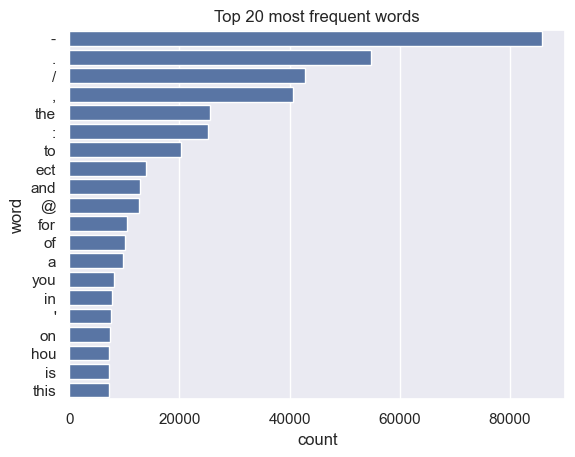

In [31]:
all_words = " ".join(df['text'].values).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)
common_words_df = pd.DataFrame(common_words, columns = ['word', 'count'])
sns.barplot(data = common_words_df, x = 'count', y = 'word')
plt.title("Top 20 most frequent words")
plt.show()

- All of the above are either stop words or punctuations
- These needs to be cleaned

In [32]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [34]:
# Split dependent and independent

x = df[['text']]
y = df['label']

x.head()

,text
0,Subject: enron methanol ; meter # : 988291\nth...
1,"Subject: hpl nom for january 9 , 2001\n( see a..."
2,"Subject: neon retreat\nho ho ho , we ' re arou..."
3,"Subject: photoshop , windows , office . cheap ..."
4,Subject: re : indian springs\nthis deal is to ...


In [35]:
y.head(2)

0    ham
1    ham
Name: label, dtype: object

In [37]:
# Train test split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, 
                                                    random_state = 0, stratify = y)

In [38]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(4136, 1) (1035, 1)
(4136,) (1035,)


# Apply data preprocessing on training data
## Text cleaning

In [58]:
def clean(doc):
    regex = "[^a-zA-Z]"
    doc = re.sub(regex, " ", doc)
    doc = doc.lower()
    tokens = nltk.word_tokenize(doc)
    stop_words = list(set(stopwords.words('english')))
    custom_stop_words = ['subject', 'hpl', 'ect', 'etc', 'hou', 'enron']
    stop_words = stop_words + custom_stop_words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    lemmatizer_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return " ".join(lemmatizer_tokens)

In [59]:
tqdm.pandas()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\younu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\younu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\younu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
x_train['clean_text'] = x_train['text'].progress_apply(lambda doc : clean(doc))
x_train.head()

100%|██████████| 4136/4136 [00:07<00:00, 518.04it/s]


,text,clean_text
2312,"Subject: hpl nom for october 26 , 2000\n( see ...",nom october see attached file hplnl xl hplnl xl
2505,"Subject: january spot tickets\ndaren ,\nhplc i...",january spot ticket daren hplc purchasing gas ...
1335,Subject: meter 1603 - 10 / 1 - 10 / 2\nfyi - m...,meter fyi meter total flow total nom deal al
2998,"Subject: july noms\ndaren ,\nplease see the vo...",july noms daren please see volume action neede...
1313,Subject: our pro - forma invoice attached\ndiv...,pro forma invoice attached divide cover gave t...


# Distributed Language Model

### Generating Word2Vec 
- Convert sentences to list of words (tokens)
- Import word2vec library from gensim
- Use word2vec to learn numeric vector for each unique words
    - word2vec chooses the list of tokens and genrate 300-dim (50- 300 dense vector) numerical vector for each word
- Convert the word vector to documents vectors

In [63]:
# Converting the sentence to list of words (list of tokens)

x_train['tokenized_sentence'] = x_train['clean_text'].apply(lambda doc : doc.split())

In [64]:
x_train.head(2)

,text,clean_text,tokenized_sentence
2312,"Subject: hpl nom for october 26 , 2000\n( see ...",nom october see attached file hplnl xl hplnl xl,"[nom, october, see, attached, file, hplnl, xl,..."
2505,"Subject: january spot tickets\ndaren ,\nhplc i...",january spot ticket daren hplc purchasing gas ...,"[january, spot, ticket, daren, hplc, purchasin..."


In [65]:
from gensim.models import Word2Vec

%time word2vec_vect = Word2Vec(x_train['tokenized_sentence'], vector_size = 300, min_count = 1)
print(word2vec_vect)

CPU times: total: 6.08 s
Wall time: 3.8 s
Word2Vec<vocab=38606, vector_size=300, alpha=0.025>


In [67]:
print(word2vec_vect.corpus_count)
print(len(word2vec_vect.wv.index_to_key))
print(word2vec_vect.vector_size)

4136
38606
300


In [68]:
def get_document_vector(doc, model):
    tokens = [word for word in doc if word in model]
    
    if tokens:
        doc_embedding = np.mean(model[tokens], axis = 0)

    else:
        doc_embedding = np.zeros(model.vector_size)

    return doc_embedding

In [69]:
x_train['w2v_doc_embeddings'] = x_train['tokenized_sentence'].apply(lambda doc : get_document_vector(doc, word2vec_vect.wv))
x_train.head()

,text,clean_text,tokenized_sentence,w2v_doc_embeddings
2312,"Subject: hpl nom for october 26 , 2000\n( see ...",nom october see attached file hplnl xl hplnl xl,"[nom, october, see, attached, file, hplnl, xl,...","[-0.19415905, 0.92785275, -0.10668858, -0.1111..."
2505,"Subject: january spot tickets\ndaren ,\nhplc i...",january spot ticket daren hplc purchasing gas ...,"[january, spot, ticket, daren, hplc, purchasin...","[0.018295972, 0.42236033, 0.48155972, 0.136866..."
1335,Subject: meter 1603 - 10 / 1 - 10 / 2\nfyi - m...,meter fyi meter total flow total nom deal al,"[meter, fyi, meter, total, flow, total, nom, d...","[-0.09566992, 0.5930712, 0.24225909, -0.121339..."
2998,"Subject: july noms\ndaren ,\nplease see the vo...",july noms daren please see volume action neede...,"[july, noms, daren, please, see, volume, actio...","[-0.036320064, 0.5580821, 0.37397793, 0.130175..."
1313,Subject: our pro - forma invoice attached\ndiv...,pro forma invoice attached divide cover gave t...,"[pro, forma, invoice, attached, divide, cover,...","[0.01586063, 0.32710135, 0.21483086, 0.0273930..."


# Building ML model (Logistic Regression and Random Forest)

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [71]:
x_test['clean_text'] = x_test['text'].progress_apply(lambda doc : clean(doc))

100%|██████████| 1035/1035 [00:02<00:00, 512.61it/s]


In [72]:
x_test['tokenized_sentence'] = x_test['clean_text'].apply(lambda doc : doc.split())

In [74]:
%time word2vec_vect_test = Word2Vec(x_test['tokenized_sentence'], vector_size = 300, min_count = 1)

CPU times: total: 1.48 s
Wall time: 1.01 s


In [75]:
x_test['w2v_doc_embeddings'] = x_test['tokenized_sentence'].apply(lambda doc : get_document_vector(doc, word2vec_vect.wv))

In [84]:
# Building the model

classifier = LogisticRegression()
%time classifier.fit(list(x_train['w2v_doc_embeddings']), y_train)

# Predincting on unseen data
y_test_pred = classifier.predict(list(x_test['w2v_doc_embeddings']))

# Model evaluation
print()
print(f"Model's Accuracy (Logistic regression) : {(metrics.accuracy_score(y_test, y_test_pred))}")

CPU times: total: 62.5 ms
Wall time: 159 ms

Model's Accuracy (Logistic regression) : 0.9420289855072463


In [85]:
# Building the model

rfclassifier = RandomForestClassifier()
%time rfclassifier.fit(list(x_train['w2v_doc_embeddings']), y_train)

# Predincting on unseen data
y_test_pred_rf = rfclassifier.predict(list(x_test['w2v_doc_embeddings']))

# Model evaluation
print()
print(f"Model's Accuracy (Random Forest) : {(metrics.accuracy_score(y_test, y_test_pred_rf))}")

CPU times: total: 8.84 s
Wall time: 11.6 s

Model's Accuracy (Random Forest) : 0.9449275362318841
